# Machine Learning Approaches to Better Utilize HM450K Data in Cancer Analysis
## Aim 1: Utilize Machine Learning to Identify Breast Cancer Subtypes
### Approach 1: Can K-means unsupervised clustering effectively identify clusters in breast cancer and how well do those clusters align with known subtypes?

In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import multiprocessing
import pprint

import matplotlib.pyplot as plt
import pandas as pd
import shap
from matplotlib.colors import to_rgba
from sklearn.cluster import KMeans
from sklearn.decomposition import KernelPCA
from sklearn.impute import SimpleImputer
from sklearn.metrics import normalized_mutual_info_score
from sklearn.pipeline import Pipeline
from utils import *

#### Load and prep the data

The first step in this analysis is to load the data in and prep it. To do this, we will remove any features that do now have any data

In [2]:
X, y = get_subtype_ml_data()

In [3]:
y.nunique()

5

In [4]:
X_filtered = X.dropna(axis=1, how='all')
print(f"Filtered {X.shape[1] - X_filtered.shape[1]} columns")

Filtered 36529 columns


### Create a pipeline to cluster the breast cancer data

Step 1 - Impute missing data

Step 2 - Utilize K-means to identify clusters matching the number of breast cancer subtypes in our dataset

In [6]:
pipeline = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="mean")),
        ("kmeans", KMeans(n_clusters=y.nunique(), random_state=RANDOM_STATE, n_init="auto")),
    ]
)

In [7]:
pipeline.fit(X_filtered)

Pipeline(steps=[('imputer', SimpleImputer()),
                ('kmeans',
                 KMeans(n_clusters=5, n_init='auto', random_state=42))])

In [8]:
# n_jobs = multiprocessing.cpu_count() // 2
n_jobs = 5

### Create a pipeline for visualization of the clusters

In order to visualize the clusters, we will use dimensionality reduction via KPCA to identify 2 principal components and plot the clusters

Step 1 - Impute missing data

Step 2 - Run data through KPCA

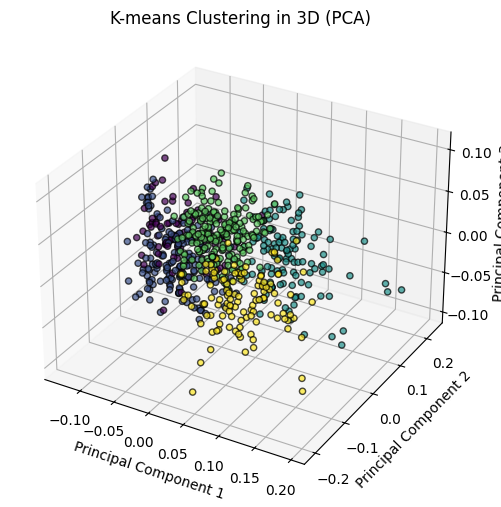

In [9]:
labels = pipeline.named_steps["kmeans"].labels_

pca_pipeline = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="mean")),
        ("pca", KernelPCA(n_components=3, kernel="rbf", random_state=RANDOM_STATE, n_jobs=n_jobs)),
    ]
)
X_pca = pca_pipeline.fit_transform(X_filtered)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    X_pca[:, 2],
    c=labels,
    cmap="viridis",
    marker="o",
    edgecolor="k",
    alpha=0.7,
)
ax.set_title("K-means Clustering in 3D (PCA)")
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_zlabel("Principal Component 3")
plt.show()

In [10]:
kmeans_labels = pipeline.named_steps["kmeans"].labels_

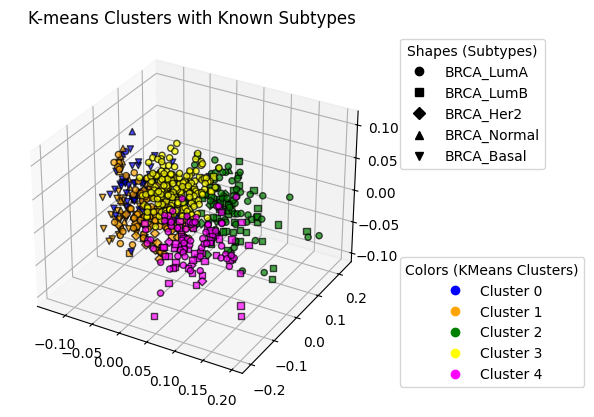

In [11]:
fig = plt.figure(figsize=(16, 8))

ax2 = fig.add_subplot(132, projection="3d")
colors = ["blue", "orange", "green", "yellow", "magenta"]
shapes = {
    subtype: shape for subtype, shape in zip(y.unique(), ["o", "s", "D", "^", "v"])
}
color_map = {cluster: color for cluster, color in zip(range(len(colors)), colors)}

# Plot data points with separate colors for kmeans clusters and shapes for known subtypes
for subtype, shape in shapes.items():
    mask = y == subtype
    for cluster in range(len(colors)):
        cluster_mask = (y == subtype) & (kmeans_labels == cluster)
        ax2.scatter(
            X_pca[cluster_mask, 0],
            X_pca[cluster_mask, 1],
            X_pca[cluster_mask, 2],
            c=[to_rgba(color_map[cluster])],
            marker=shape,
            edgecolor="k",
            alpha=0.7,
        )

# Create handles for shape legend
shape_handles = [
    plt.Line2D([], [], color="k", marker=shape, linestyle="", label=label)
    for label, shape in shapes.items()
]

# Create handles for color legend
color_handles = [
    plt.Line2D(
        [], [], color=color, marker="o", linestyle="", label=f"Cluster {cluster}"
    )
    for cluster, color in color_map.items()
]

# Add legends for shapes and colors
legend1 = ax2.legend(
    handles=shape_handles,
    title="Shapes (Subtypes)",
    loc="upper left",
    bbox_to_anchor=(1.05, 1),
)
legend2 = ax2.legend(
    handles=color_handles,
    title="Colors (KMeans Clusters)",
    loc="upper left",
    bbox_to_anchor=(1.05, 0.4),
)

# Adjust figure to fit both legends without excessive white space
fig.subplots_adjust(right=0.9)

ax2.add_artist(legend1)
ax2.set_title("K-means Clusters with Known Subtypes")

plt.show()

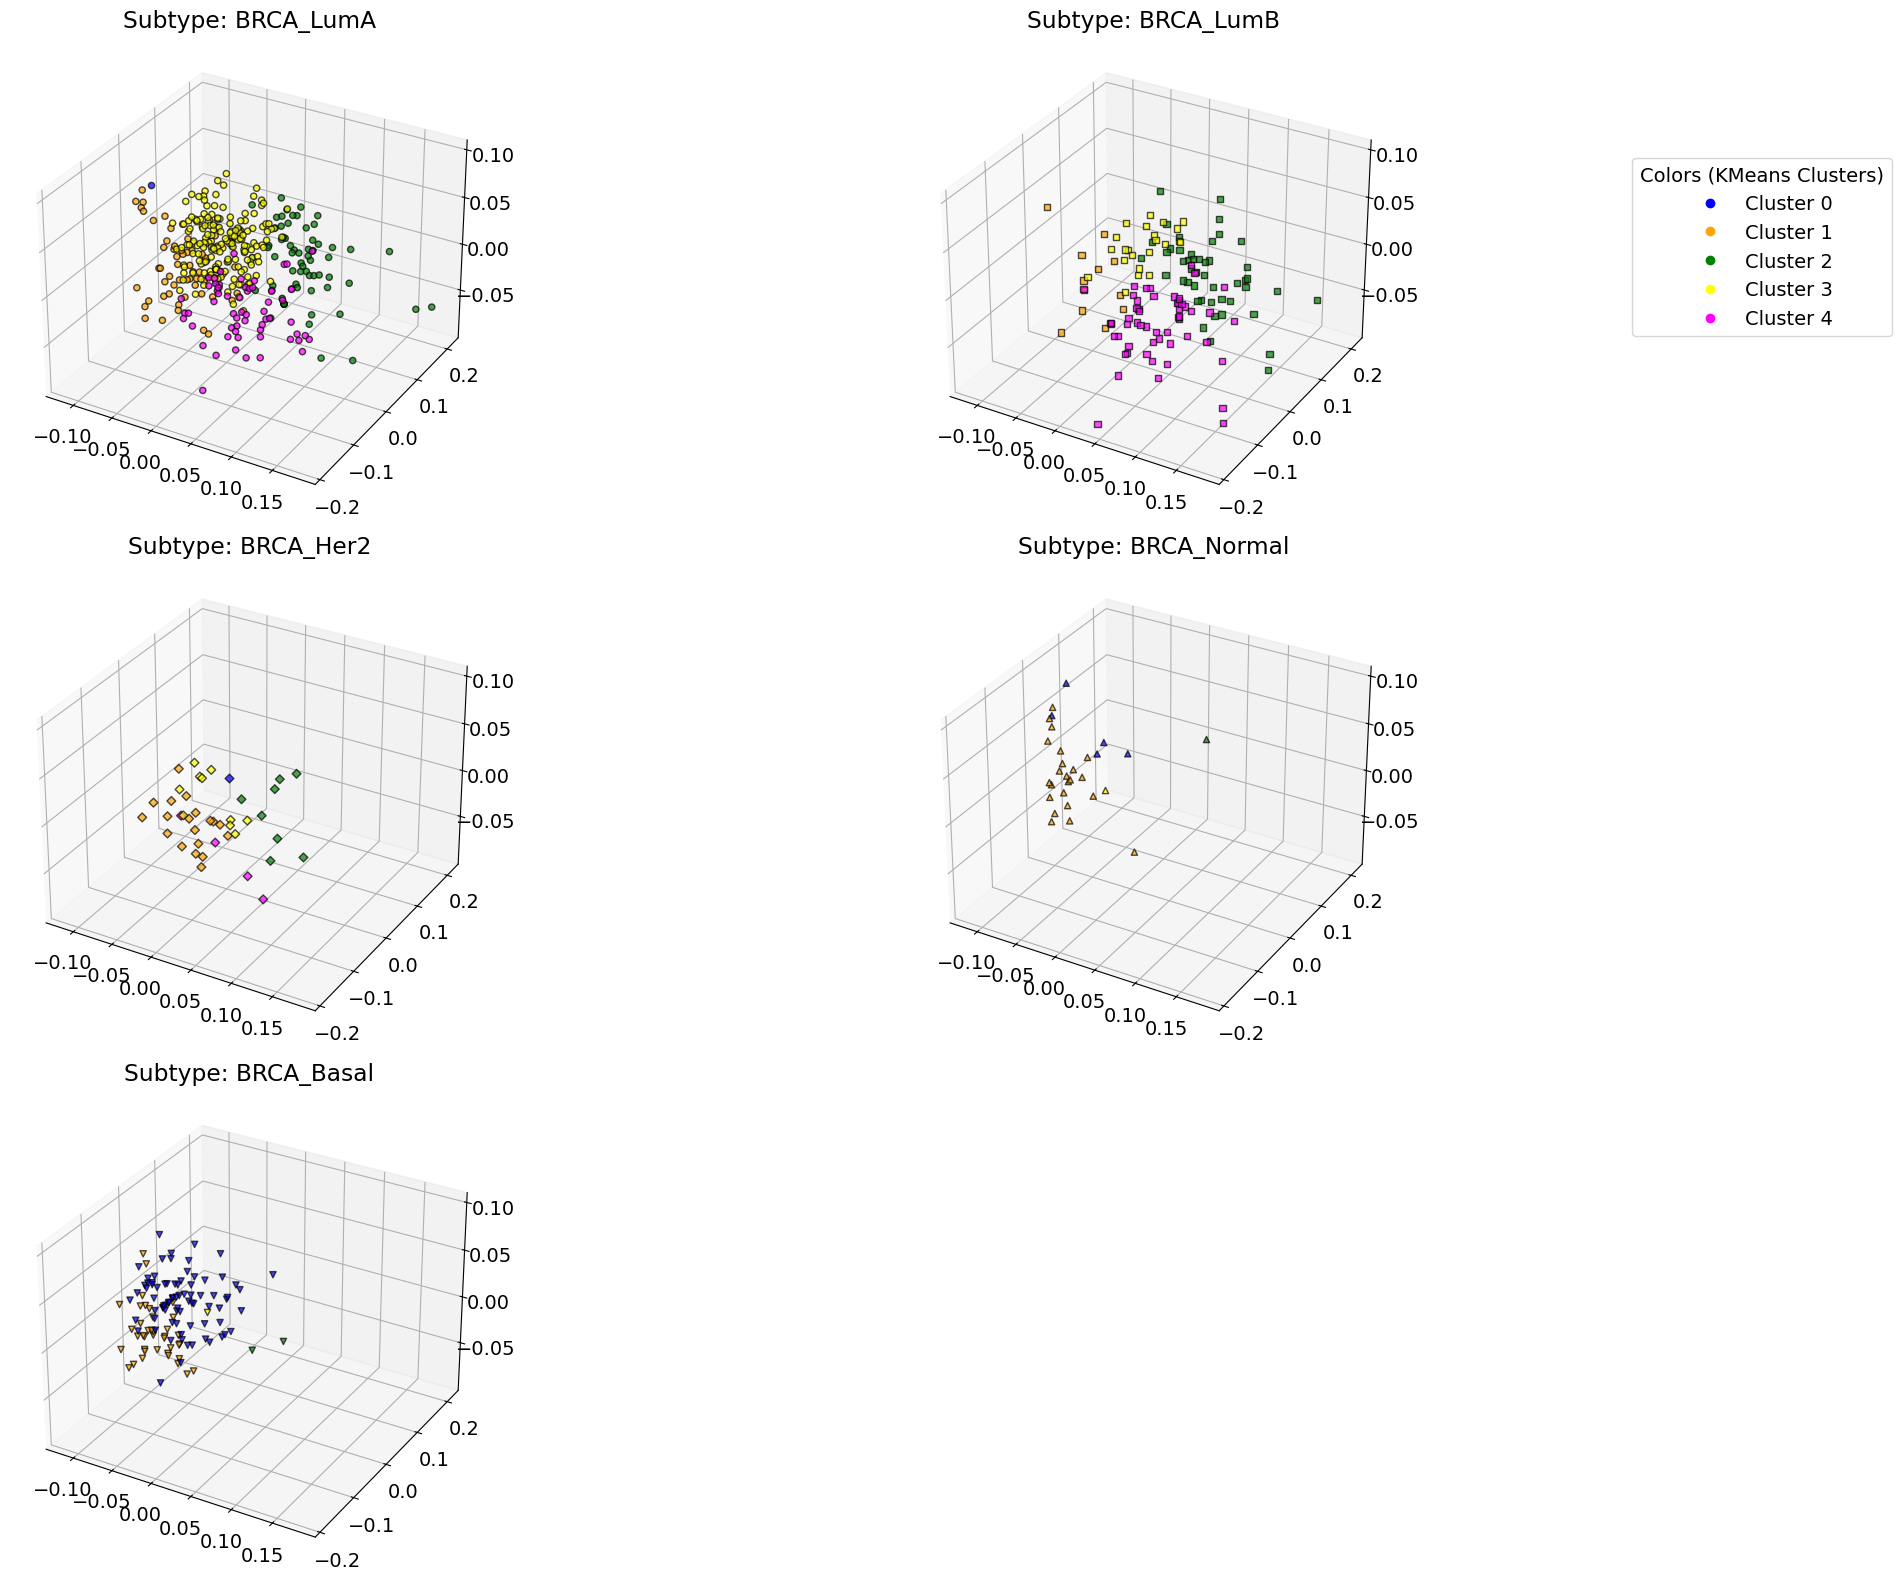

In [12]:
plt.rcParams.update({"font.size": 14})

fig = plt.figure(figsize=(20, 16))

colors = ["blue", "orange", "green", "yellow", "magenta"]
shapes = {
    subtype: shape for subtype, shape in zip(y.unique(), ["o", "s", "D", "^", "v"])
}
color_map = {cluster: color for cluster, color in zip(range(len(colors)), colors)}

# Determine min and max for all axes
x_min, x_max = X_pca[:, 0].min(), X_pca[:, 0].max()
y_min, y_max = X_pca[:, 1].min(), X_pca[:, 1].max()
z_min, z_max = X_pca[:, 2].min(), X_pca[:, 2].max()

# Create subplots for each subtype
axes = []
for i, subtype in enumerate(shapes.keys()):
    ax = fig.add_subplot(3, 2, i + 1, projection="3d")
    axes.append(ax)
    shape = shapes[subtype]
    mask = y == subtype

    # Plot data points for each kmeans cluster with unique colors
    for cluster in range(len(colors)):
        cluster_mask = (y == subtype) & (kmeans_labels == cluster)
        ax.scatter(
            X_pca[cluster_mask, 0],
            X_pca[cluster_mask, 1],
            X_pca[cluster_mask, 2],
            c=[to_rgba(color_map[cluster])],
            marker=shape,
            edgecolor="k",
            alpha=0.7,
        )

    # Set axis limits to be consistent across all plots
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_zlim(z_min, z_max)

    ax.set_title(f"Subtype: {subtype}")

# Create handles for color legend
color_handles = [
    plt.Line2D(
        [], [], color=color, marker="o", linestyle="", label=f"Cluster {cluster}"
    )
    for cluster, color in color_map.items()
]

# Add a single legend for colors to the figure
fig.legend(
    handles=color_handles,
    title="Colors (KMeans Clusters)",
    loc="upper right",
    bbox_to_anchor=(1.1, 0.9),
)

plt.tight_layout()
plt.show()

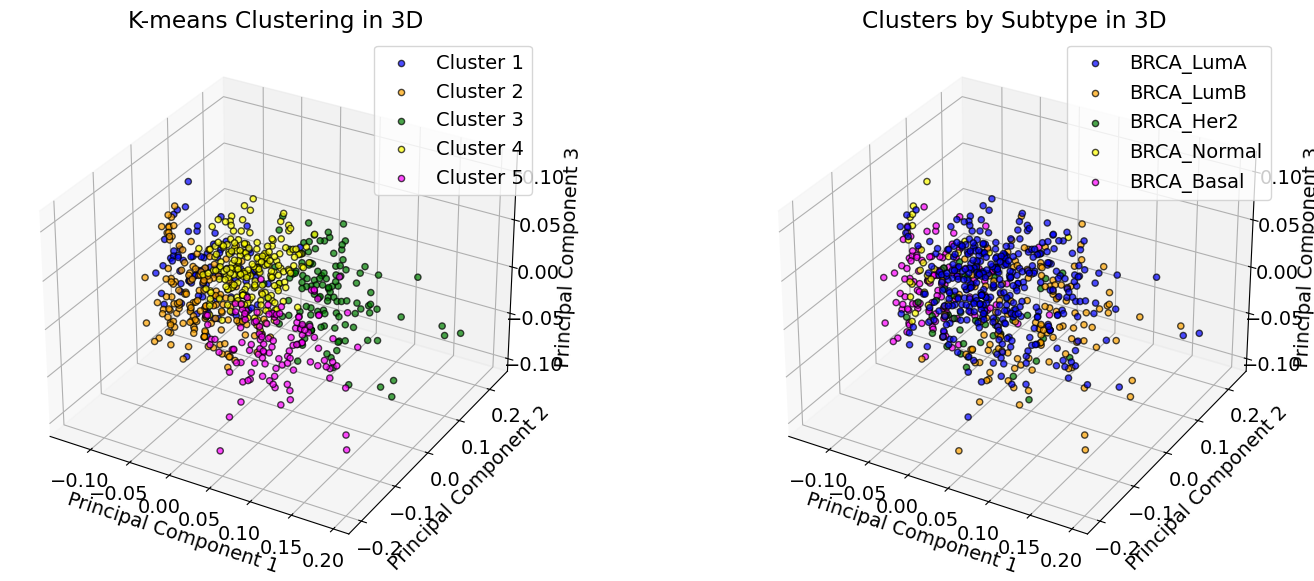

In [13]:
plt.rcParams.update({"font.size": 14})
fig = plt.figure(figsize=(16, 6))
ax1 = fig.add_subplot(121, projection="3d")
colors = ["blue", "orange", "green", "yellow", "magenta"]  
for i in range(5):
    cluster_points = X_pca[kmeans_labels == i]
    ax1.scatter(
        cluster_points[:, 0],
        cluster_points[:, 1],
        cluster_points[:, 2],
        color=colors[i],
        marker="o",
        edgecolor="k",
        alpha=0.7,
        label=f"Cluster {i+1}",
    )
ax1.set_title("K-means Clustering in 3D")
ax1.set_xlabel("Principal Component 1")
ax1.set_ylabel("Principal Component 2")
ax1.set_zlabel("Principal Component 3")
ax1.legend()

ax2 = fig.add_subplot(122, projection="3d")
subtype_colors = {
    subtype: color
    for subtype, color in zip(
        y.unique(),
        ["blue", "orange", "green", "yellow", "magenta"],
    )
}

for subtype, color in subtype_colors.items():
    mask = y == subtype
    ax2.scatter(
        X_pca[mask, 0],
        X_pca[mask, 1],
        X_pca[mask, 2],
        color=color,
        label=subtype,
        edgecolor="k",
        alpha=0.7,
    )
ax2.set_title("Clusters by Subtype in 3D")
ax2.set_xlabel("Principal Component 1")
ax2.set_ylabel("Principal Component 2")
ax2.set_zlabel("Principal Component 3")
ax2.legend()

plt.tight_layout()
plt.show()

In [21]:
nmi_score = normalized_mutual_info_score(y, kmeans_labels)
print(f"Normalized Mutual Information (NMI) score: {nmi_score}")

Normalized Mutual Information (NMI) score: 0.2902305812151664


In [14]:
shap.initjs()

In [15]:
feature_names = X_filtered.columns
feature_names

Index(['cg21870274', 'cg08258224', 'cg16619049', 'cg18147296', 'cg13938959',
       'cg12445832', 'cg23999112', 'cg11527153', 'cg27573606', 'cg04195702',
       ...
       'cg26348521', 'cg03370490', 'cg16974513', 'cg23628760', 'cg04920704',
       'cg07236001', 'cg27267896', 'cg23079702', 'cg21073216', 'cg22820726'],
      dtype='object', name='id', length=238569)

In [16]:
def model_fit_transform(data_asarray):
    data_asframe = pd.DataFrame(data_asarray, columns=feature_names)
    return pipeline.transform(data_asframe)

In [17]:
explainer = shap.KernelExplainer(model_fit_transform, shap.sample(X_filtered, 10, random_state=RANDOM_STATE))

In [18]:
explainer(X_filtered.iloc[0])

MemoryError: Unable to allocate 8.31 TiB for an array with shape (478880, 2385690) and data type float64

In [ ]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    pipeline,
    X_filtered,
    None,
    n_repeats=5,
    random_state=RANDOM_STATE,
    n_jobs=20,
)

# Map importance scores to original feature names
feature_importances = dict(zip(feature_names, result.importances_mean))